In [1]:
!pip install fastapi uvicorn nest-asyncio pyngrok opencv-python-headless

In [2]:
!npm install -g localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴
added 22 packages in 3s
⠦
⠦3 packages are looking for funding
⠦  run `npm fund` for details
⠦

In [3]:
%%writefile pawos_server.py
from fastapi import FastAPI, File, UploadFile
import cv2
import numpy as np
import torch
import time
from torch.cuda.amp import autocast

app = FastAPI()
device = "cuda" if torch.cuda.is_available() else "cpu"

# Dummy GPU processing function
def run_inference(tensor):
    with autocast():
        dummy = tensor * 2
    torch.cuda.synchronize()
    return dummy

@app.post("/upload_frame")
async def upload_frame(frame: UploadFile = File(...)):
    # Convert uploaded bytes to NumPy array
    file_bytes = np.frombuffer(await frame.read(), np.uint8)
    img = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)

    # Convert to tensor for GPU
    img = cv2.resize(img, (64, 64))
    img = img.transpose(2,0,1) / 255.0
    tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0).to(device)

    start = time.time()
    output = run_inference(tensor)
    end = time.time()
    latency_ms = (end - start) * 1000

    return {"status": "frame processed", "latency_ms": latency_ms}


Writing pawos_server.py


In [4]:
import nest_asyncio
nest_asyncio.apply()

import uvicorn

import subprocess
uvicorn_process = subprocess.Popen(
    ["uvicorn", "pawos_server:app", "--host", "0.0.0.0", "--port", "8000"]
)
print("Uvicorn server started in background on port 8000.")


Uvicorn server started in background on port 8000.


In [5]:
!npm install -g localtunnel

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼
changed 22 packages in 2s
⠼
⠼3 packages are looking for funding
⠼  run `npm fund` for details
⠼

In [6]:
import subprocess
import time

# Kill any existing localtunnel processes
!pkill lt

# Start localtunnel on port 8000
lt_proc = subprocess.Popen(
    ["lt", "--port", "8000"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

# Wait a few seconds for tunnel to start
time.sleep(5)

# Read first few lines from stdout to capture URL
for i in range(5):
    line = lt_proc.stdout.readline().decode("utf-8").strip()
    if "https://" in line and ".loca.lt" in line:
        public_url = line
        break

print("Localtunnel public URL (use in laptop script):", public_url)


Localtunnel public URL (use in laptop script): your url is: https://calm-days-shave.loca.lt


In [7]:
%%writefile pawos_server.py
from fastapi import FastAPI, File, UploadFile
import cv2
import numpy as np

app = FastAPI()

@app.post("/upload_frame")
async def upload_frame(frame: UploadFile = File(...)):
    try:
        # Read uploaded file
        file_bytes = await frame.read()
        npimg = np.frombuffer(file_bytes, np.uint8)
        img = cv2.imdecode(npimg, cv2.IMREAD_COLOR)

        if img is None:
            return {"status": "failed", "reason": "Could not decode image"}

        # Print info about received image
        print(f"Received frame: shape={img.shape}")

        # Return confirmation
        return {"status": "frame received", "shape": img.shape}

    except Exception as e:
        print("Error processing frame:", e)
        return {"status": "error", "detail": str(e)}


Overwriting pawos_server.py


In [8]:
import subprocess
import time

# Kill any old processes
!pkill lt
!pkill uvicorn

# Start FastAPI server in background
uvicorn_proc = subprocess.Popen(
    ["uvicorn", "pawos_server:app", "--host", "0.0.0.0", "--port", "8000"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)
print("FastAPI server started on port 8000.")

# Start Localtunnel to expose port 8000
lt_proc = subprocess.Popen(
    ["lt", "--port", "8000"],
    stdout=subprocess.PIPE,
    stderr=subprocess.PIPE
)

# Wait for tunnel to initialize
time.sleep(5)

# Capture public URL
public_url = None
for _ in range(10):
    line = lt_proc.stdout.readline().decode("utf-8").strip()
    if "https://" in line and ".loca.lt" in line:
        public_url = line
        break

if public_url:
    print("Localtunnel public URL (use in laptop script):", public_url)
else:
    print("Could not find Localtunnel URL. Check logs.")


FastAPI server started on port 8000.
Localtunnel public URL (use in laptop script): your url is: https://pretty-chicken-dance.loca.lt


In [9]:
# ========================
# 1. Imports
# ========================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# ========================
# 2. Device (GPU if available)
# ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ========================
# 3. Dataset & Dataloaders
# ========================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize RGB
])

train_dataset = datasets.CIFAR10(root='./data', train=True,
                                 download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64,
                          shuffle=True, num_workers=2)

test_dataset = datasets.CIFAR10(root='./data', train=False,
                                download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64,
                         shuffle=False, num_workers=2)

# ========================
# 4. CNN Model
# ========================
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)

        # Corrected flatten size = 128*2*2 = 512
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MyCNN().to(device)
print(model)

# ========================
# 5. Loss & Optimizer
# ========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ========================
# 6. Training Loop
# ========================
EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1} [{batch_idx*len(data)}/{len(train_loader.dataset)}] "
                  f"Loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1} complete, Avg Loss: {running_loss/len(train_loader):.4f}")

# ========================
# 7. Evaluation
# ========================
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        outputs = model(data)
        _, predicted = torch.max(outputs, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")


Using device: cuda


100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


MyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
Epoch 1 [0/50000] Loss: 2.3111
Epoch 1 [6400/50000] Loss: 1.8477
Epoch 1 [12800/50000] Loss: 1.6725
Epoch 1 [19200/50000] Loss: 1.3306
Epoch 1 [25600/50000] Loss: 1.5462
Epoch 1 [32000/50000] Loss: 1.5492
Epoch 1 [38400/50000] Loss: 1.3590
Epoch 1 [44800/50000] Loss: 1.0400
Epoch 1 complete, Avg Loss: 1.4784
Epoch 2 [0/50000] Loss: 1.2061
Epoch 2 [6400/50000] Loss: 1.0737
Epoch 2 [12800/50000] Loss: 1.1563
Epoch 2 [19200/50000] Loss: 1.0715
Epoch 2 [25600/50000] Loss: 

Using device: cuda
MyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=512, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
Epoch 1, Step 0, Loss: 2.3016
Epoch 1, Step 200, Loss: 1.5877
Epoch 1, Step 400, Loss: 1.3074
Epoch 1, Step 600, Loss: 1.0885
Epoch 1 complete, Avg Loss: 1.4889
Epoch 2, Step 0, Loss: 1.1550
Epoch 2, Step 200, Loss: 0.9444
Epoch 2, Step 400, Loss: 1.0781
Epoch 2, Step 600, Loss: 1.0501
Epoch 2 complete, Avg Loss: 1.0330


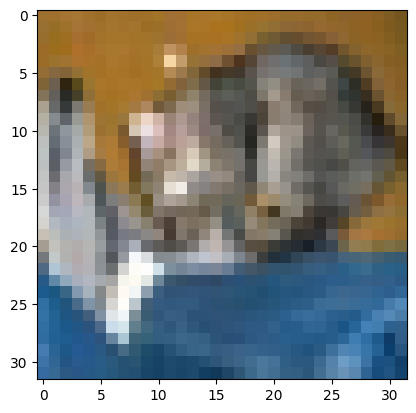

Ground Truth: cat
Predicted   : cat


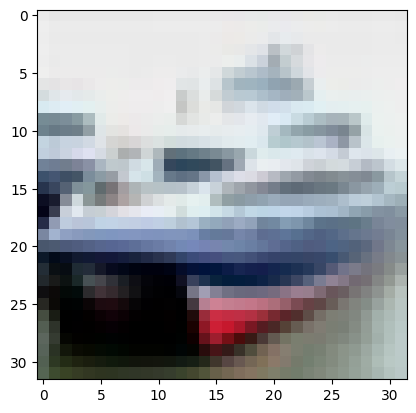

Ground Truth: ship
Predicted   : ship


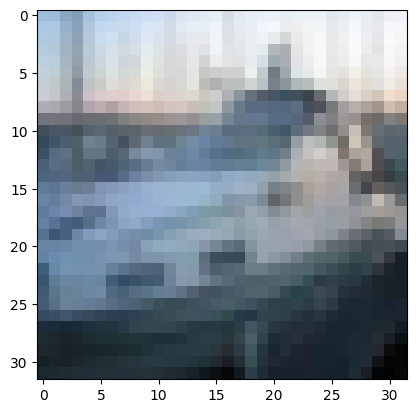

Ground Truth: ship
Predicted   : ship


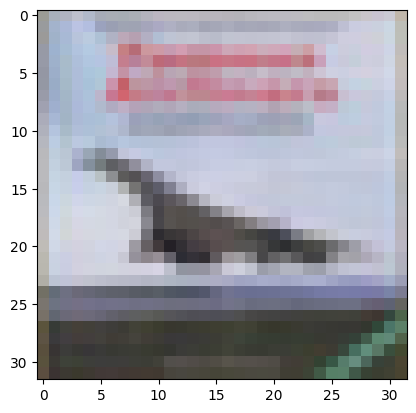

Ground Truth: airplane
Predicted   : airplane


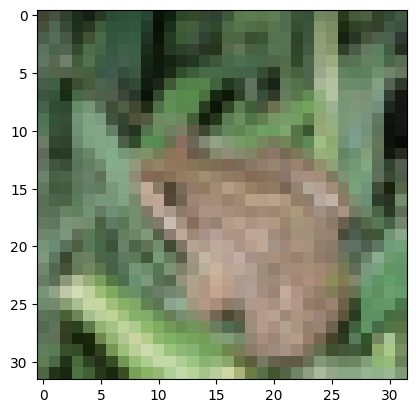

Ground Truth: frog
Predicted   : frog


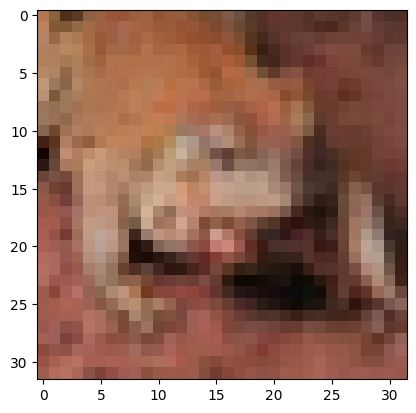

Ground Truth: frog
Predicted   : frog


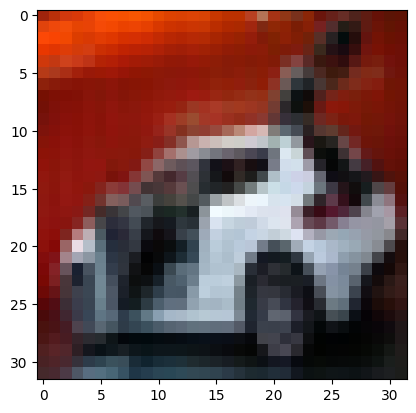

Ground Truth: automobile
Predicted   : automobile


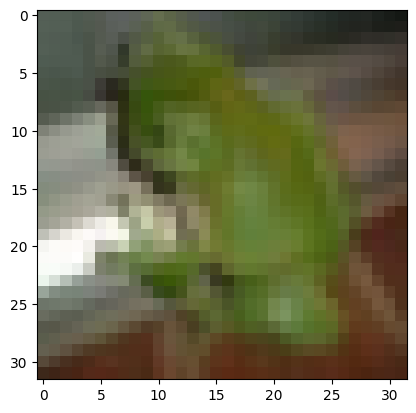

Ground Truth: frog
Predicted   : deer


In [10]:
# ========================
# 1. Imports
# ========================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# ========================
# 2. Device (GPU if available)
# ========================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ========================
# 3. Dataset & Dataloaders
# ========================
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # normalize RGB
])

train_dataset = datasets.CIFAR10(root='./data', train=True,
                                 download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64,
                          shuffle=True, num_workers=2)

test_dataset = datasets.CIFAR10(root='./data', train=False,
                                download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=64,
                         shuffle=False, num_workers=2)

# ========================
# 4. CNN Model
# ========================
class MyCNN(nn.Module):
    def __init__(self):
        super(MyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, 3, padding=1)

        # Final feature map size after pooling = 128 * 2 * 2 = 512
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MyCNN().to(device)
print(model)

# ========================
# 5. Loss & Optimizer
# ========================
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ========================
# 6. Training Loop
# ========================
EPOCHS = 2   # keep small for quick run
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if batch_idx % 200 == 0:
            print(f"Epoch {epoch+1}, Step {batch_idx}, Loss: {loss.item():.4f}")

    print(f"Epoch {epoch+1} complete, Avg Loss: {running_loss/len(train_loader):.4f}")

# ========================
# 7. Test some images (focus on 'cat' class)
# ========================
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

classes = train_dataset.classes  # CIFAR-10 labels

dataiter = iter(test_loader)
images, labels = next(dataiter)

images, labels = images.to(device), labels.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

for i in range(8):  # show 8 images
    imshow(images[i].cpu())
    print(f"Ground Truth: {classes[labels[i]]}")
    print(f"Predicted   : {classes[predicted[i]]}")


In [11]:
print("CUDA available:", torch.cuda.is_available())
print("Number of GPUs:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))


CUDA available: True
Number of GPUs: 1
GPU name: Tesla T4
